In [48]:
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import plotly as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as mpl
import dash
from dash import html
from dash import dcc


from dotenv import load_dotenv
load_dotenv()


pd.options.plotting.backend = "plotly"


In [2]:
database_uri = os.environ['DATABASE_URI']
connection = psycopg2.connect(database_uri)

In [3]:
df = pd.read_csv('Telco-Churn.csv')
df
#in below dict we will store every action, which edited the dataset
taken_actions = dict()

In [4]:
df.describe

<bound method NDFrame.describe of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DS

In [5]:
#df.isna().sum()
df['DeviceProtection'].value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

In [39]:
df['InternetService'].value_counts()

Fiber-optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [6]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
taken_actions['1'] = 'changed TotalCharges column from type object to numeric, argument "errors" had been set to "coerce"'
df.dropna(inplace=True)
taken_actions['2'] = 'droped NAs'
for col in df.columns:
    df[col] = df[col].replace(to_replace=' ', value='-', regex=True)
taken_actions['2'] = 'replaced spaces from values of rows to a dash (-)'


In [7]:
#we save the data to a database after cleaning is done
db = create_engine(database_uri)
#with db.connect() as conn:
    #df.to_sql('telco_churn', conn, if_exists='replace')

In [8]:
connection = psycopg2.connect(database_uri)

In [9]:

#pre-create traces
monthly_charges_trace = go.Box(y=df['MonthlyCharges'], name='Monthly Charges')
total_charges_trace = go.Box(y=df['TotalCharges'], name='Total Charges')


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    monthly_charges_trace,
    secondary_y=False,
)

fig.add_trace(
    total_charges_trace,
    secondary_y=True,
)
#prettify
fig.update_layout(
    showlegend=False,
    width = 900,
    margin = {'t' : 50, 'b': 50}
)
fig.show()

In [10]:
df[['MultipleLines']].value_counts()

# below we have queries to use as CREATE_PHONESERVICE_VIEW's value
# below SQL query sets MultipleLines values as rows's values
# CREATE VIEW phone_service_view AS
# SELECT 
# "MultipleLines", COUNT("MultipleLines")
# FROM telco_churn
# GROUP BY "MultipleLines";

# below a query which sets MultipleLines values as columns, but returns three identical rows,
# CREATE VIEW phone_service_view AS
# SELECT 
# (SELECT COUNT("MultipleLines") AS "Yes" FROM telco_churn WHERE "MultipleLines" = 'Yes'),
# (SELECT COUNT("MultipleLines") AS "No" FROM telco_churn WHERE "MultipleLines" = 'No'),
# (SELECT COUNT("MultipleLines") AS "No_Phone_Service" FROM telco_churn WHERE "MultipleLines" = 'No-phone-service') 
# FROM telco_churn
# GROUP BY "MultipleLines";

MultipleLines   
No                  3385
Yes                 2967
No-phone-service     680
dtype: int64

In [11]:
#now we will make chart of amount of customers using additional services, let's begin from Phone Service
CREATE_PHONESERVICE_VIEW = """CREATE VIEW phone_service_view AS
SELECT 
"MultipleLines", COUNT("MultipleLines")
FROM telco_churn
GROUP BY "MultipleLines";"""
PHONE_SERVICE_VIEW = "SELECT * FROM phone_service_view;"
try:
    with connection:
        with connection.cursor() as cursor:
            cursor.execute(CREATE_PHONESERVICE_VIEW)
except:
    pass
finally: 
    with db.connect() as conn:
        phone_service = pd.read_sql_query(PHONE_SERVICE_VIEW, conn)

#phone_service["Amount-of-users"] = 'Amount of users'
phone_service.sort_values('count', ascending=False, inplace=True)
phone_service

,MultipleLines,count
0,No,3385
2,Yes,2967
1,No-phone-service,680


In [12]:
# phone_service_fig = px.bar(phone_service, x='count', y='Amount-of-users',
#                             color='MultipleLines', orientation='h',
#                             height = 250, width=800,
#                             text='MultipleLines',
#                             ) 
# phone_service_fig.layout.update(showlegend=False)                          
# phone_service_trace = [go.Bar(
#         name='No',
#         x=[3385],
#         y=["Multiple Lines"],
#         orientation='h',
#         text='No'),
#     go.Bar(
#         name='Yes',
#         x=[2967],
#         y=["Multiple Lines"],
#         orientation='h',
#         text='Yes'),
#     go.Bar(
#         name='No phone service',
#         x=[680],
#         y=["Multiple Lines"],
#         orientation='h',
#         text='No phone service')
# ]
# fig = go.Figure(data=phone_service_trace)
# fig.update_layout(barmode='stack')
# fig.show()

In [13]:
services_traces = list()
for ind, row in phone_service.iterrows():
    trace = go.Bar(
        name = row['MultipleLines'],
        x=[row['count']],
        y=["Multiple Lines"],
        orientation='h',
        text=row["MultipleLines"], textangle=0
    )
    services_traces.append(trace)


In [14]:
# online_security = df['OnlineSecurity'].value_counts().to_frame()
# online_security.reset_index(inplace=True, names='Service')
# online_security
# for ind, row in online_security.iterrows():
#     trace = go.Bar(
#         name = row['Service'],
#         x=[row['OnlineSecurity']],
#         y=["Service"],
#         orientation='h',
#         text=row["Service"], textangle=0
#     )
#     services_traces.append(trace)


In [15]:
services = df.loc[:, 'DeviceProtection':'StreamingMovies']  # we will iterate through these columns to create traces and append them to a list
for column in services:
    service_count = df[column].value_counts().to_frame() # count yes and no
    service_count.reset_index(inplace=True, names='Service') # we don't want answer as an index
    for ind, row in service_count.iterrows():
        trace = go.Bar(
            name = row['Service'],
            x=[row[column]],
            y=[column],
            orientation='h',
            text=row['Service'], textangle=0
        )
        services_traces.append(trace)


In [16]:
services_fig = go.Figure(data=services_traces)
services_fig.update_traces(width=0.3)
services_fig.update_layout(barmode='stack', width=1100, showlegend=False)
services_fig.show()

In [91]:
# we can see above, that there we have more users who are using our phone services only, than these, who use internet services only

# belowe function will be used to service creation a view and retrieving a view from it
def service_query(creating_query: str, calling_query: str) -> pd.DataFrame():
    try:
        with connection:
            with connection.cursor() as cursor:
                cursor.execute(creating_query)
    except Exception:
        pass
    finally: 
        with db.connect() as conn:
            frame = pd.read_sql_query(calling_query, conn)
    return frame


In [100]:
CREATE_CONTRACT_VIEW = """CREATE VIEW contract_view AS
SELECT
"Contract",
"Churn",
COUNT("Churn")
FROM telco_churn
GROUP BY "Contract", "Churn"
ORDER BY "Contract";"""
CONTRACT_VIEW = "SELECT * FROM contract_view;"
contract_frame = service_query(CREATE_CONTRACT_VIEW, CONTRACT_VIEW)
contract_figure = px.bar(contract_frame, x='Contract', y='count', color='Churn')
contract_figure.show()
# well, this chart doesn't tell us much after all

<class 'Exception'>


In [97]:
CREATE_CHARGES_VIEW = """CREATE VIEW charges AS
SELECT 
"MonthlyCharges",
"TotalCharges",
"Churn",
ROUND("TotalCharges"/"MonthlyCharges") AS Months
FROM telco_churn;"""
CHARGES_VIEW = "SELECT * FROM charges;"
charges = service_query(CREATE_CHARGES_VIEW, CHARGES_VIEW)

churn_numeric = pd.get_dummies(charges['Churn'])    
charges['Left'] = churn_numeric['Yes']
charges['Stayed'] = churn_numeric['No']
charges

,MonthlyCharges,TotalCharges,Churn,months,Left,Stayed
0,29.85,29.85,No,1.0,0,1
1,56.95,1889.50,No,33.0,0,1
2,53.85,108.15,Yes,2.0,1,0
3,42.30,1840.75,No,44.0,0,1
4,70.70,151.65,Yes,2.0,1,0
...,...,...,...,...,...,...
7027,84.80,1990.50,No,23.0,0,1
7028,103.20,7362.90,No,71.0,0,1
7029,29.60,346.45,No,12.0,0,1
7030,74.40,306.60,Yes,4.0,1,0


In [50]:
churn_fig = px.scatter(charges, x='months', y='MonthlyCharges', color='Churn', hover_data=['Churn'])
churn_fig.update_traces(marker_size=4)
churn_fig.show()

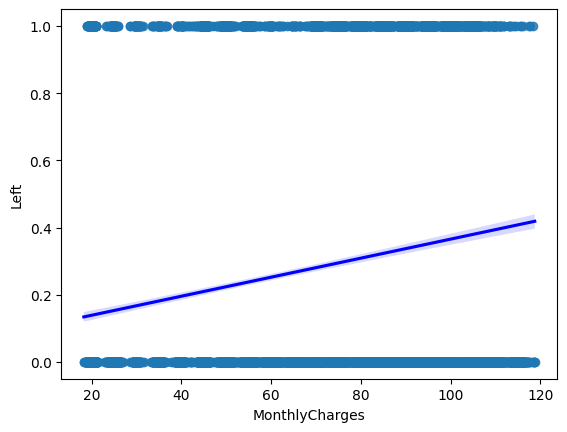

In [43]:
sns.regplot(x=charges["MonthlyCharges"], y=charges["Left"], line_kws={"color":"b"})
mpl.show()

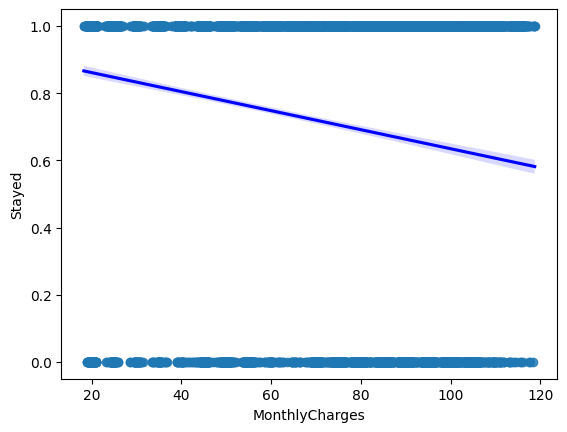

In [44]:
sns.regplot(x=charges["MonthlyCharges"], y=charges["Stayed"], line_kws={"color":"b"})
mpl.show()

In [49]:
app=dash.Dash(__name__)
app.layout = html.Div(children=[html.H1('Telco churn Dashboard',
                                style={'textAlign':'center',
                                        'color':'#503D36',
                                        'font-size':40}),
                                html.P(html.P('Proportion of distance group (250 mile distance interval group) by flights.',
                                 style={'textAlign':'center', 'color': '#F57241'})),
                                dcc.Graph(figure=fig),

                    ])

# Run the application                   
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_6_2m1664709970.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash/deps/react@16.v2_6_2m1664709970.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_6_2m1664709970.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_6_2m1664709970.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_6_2m1664709970.min.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_6_2m1664709970.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2022 13:27:54] "GET /_dash-component-suites/dash